<a href="https://colab.research.google.com/github/ArjunChandwadkar/quant-options-engine/blob/main/heatmap_%26_monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-48665813.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period, interval=interval)["Close"]
[*********************100%***********************]  10 of 10 completed


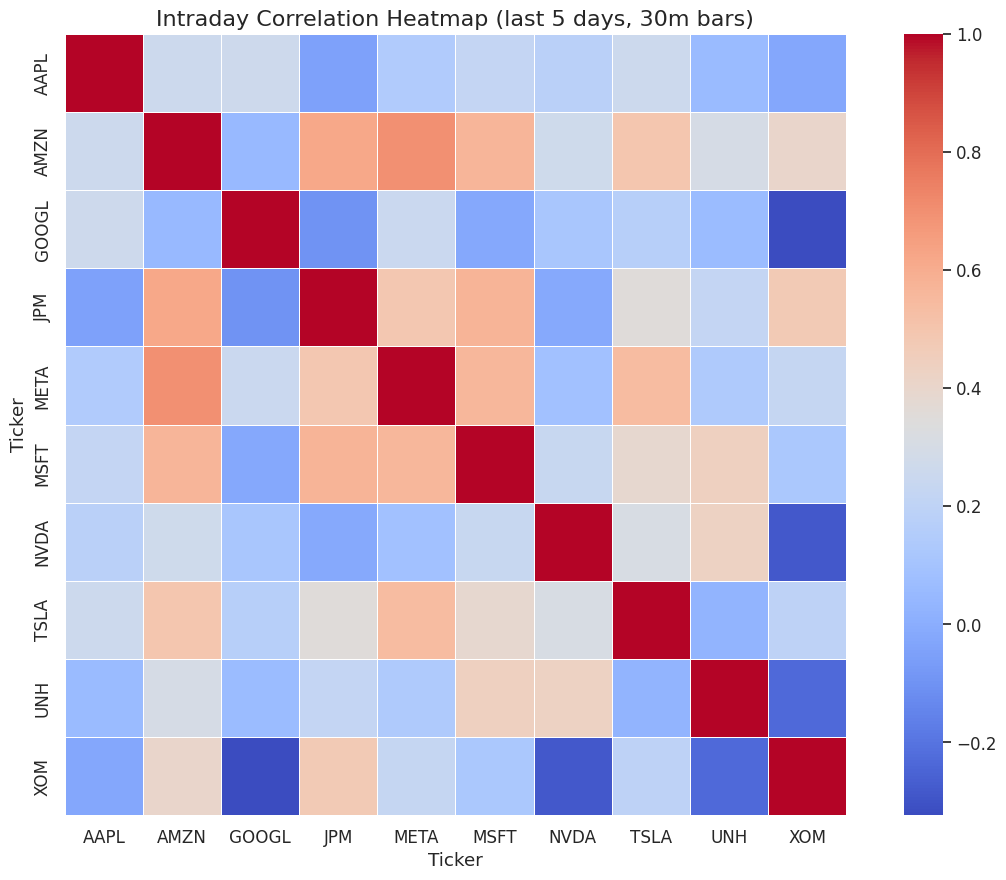

/tmp/ipython-input-48665813.py:62: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period, interval="1d")["Close"]
[*********************100%***********************]  10 of 10 completed



========== AAPL ==========
S0=286.19, mu=0.2244, sigma=0.3274
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


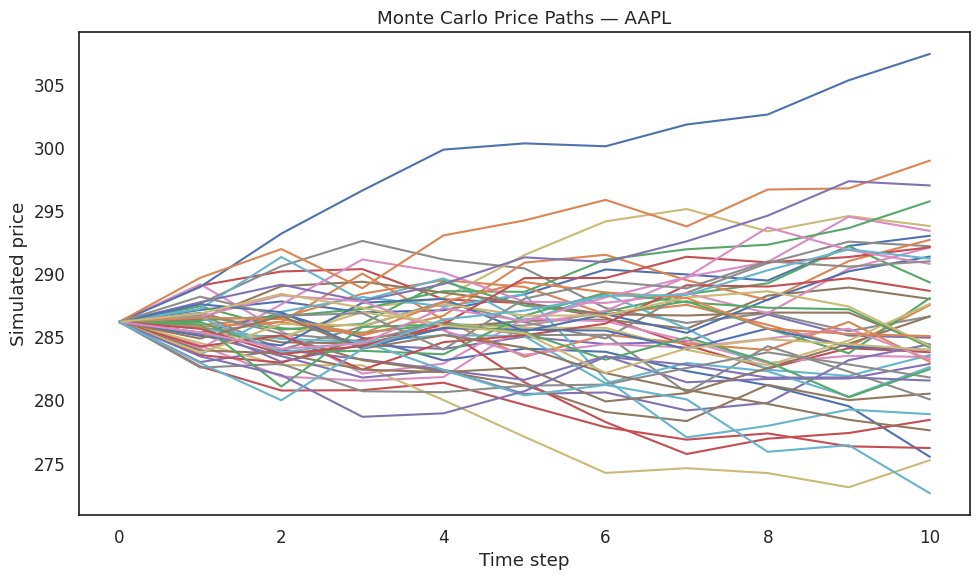

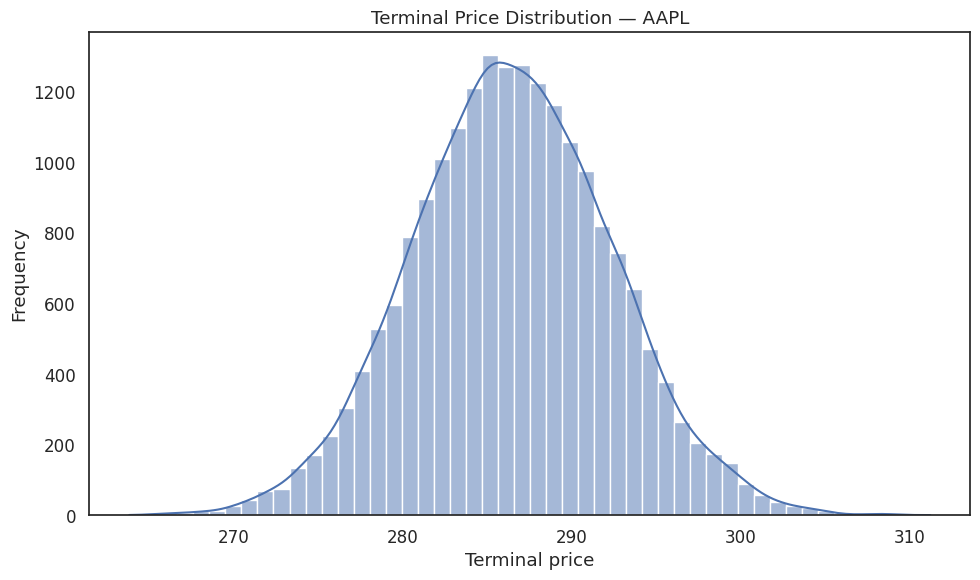

Pricing 5 calls & 5 puts


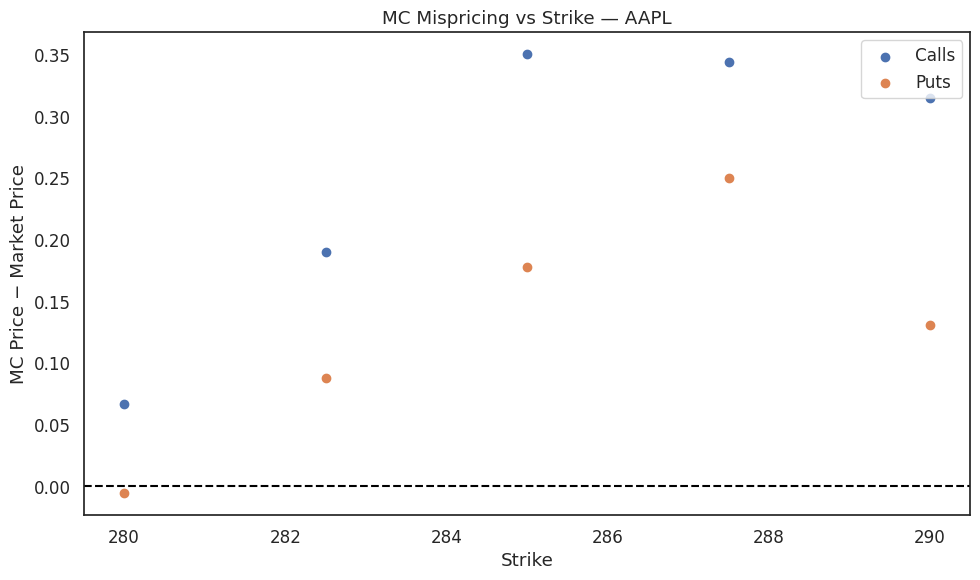


========== MSFT ==========
S0=490.00, mu=0.1661, sigma=0.2440
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


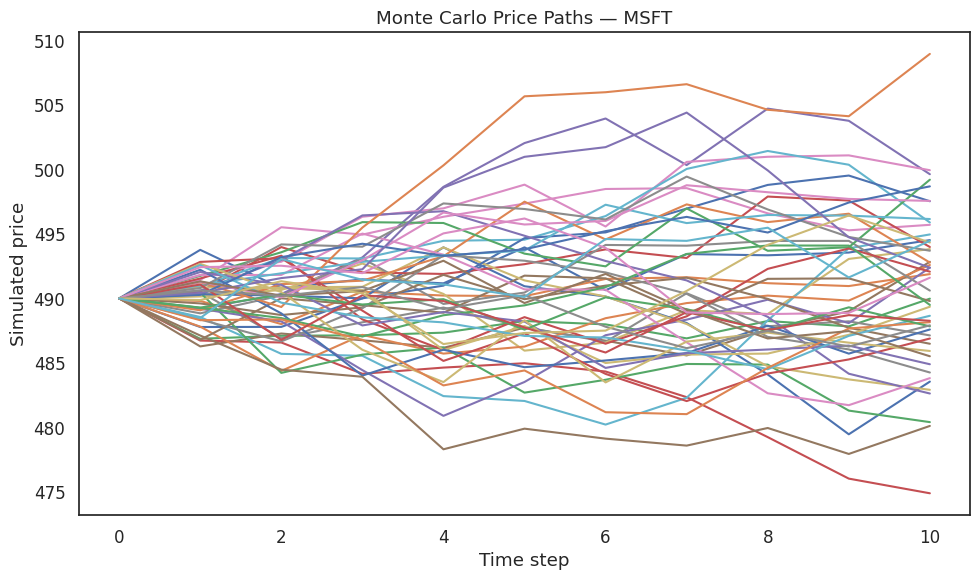

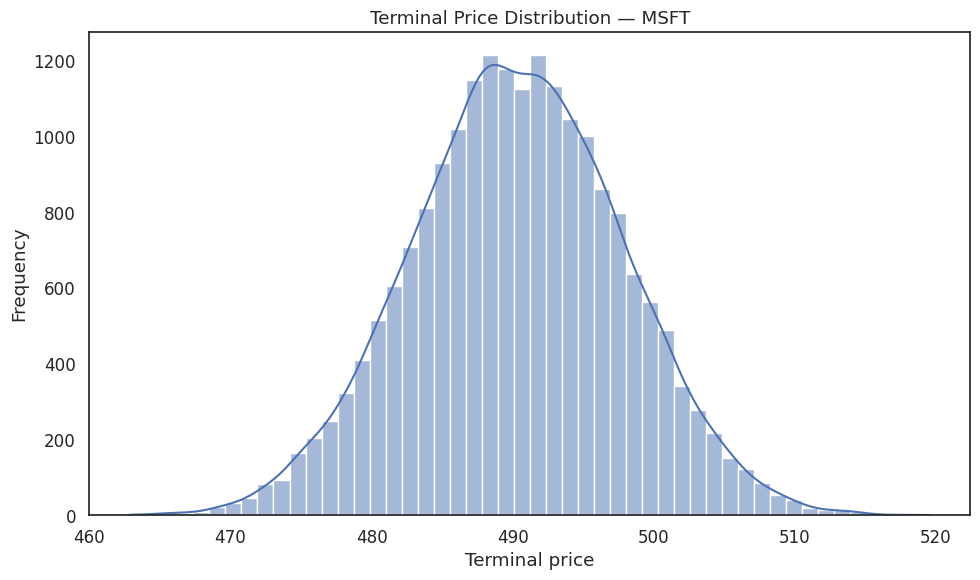

Pricing 5 calls & 5 puts


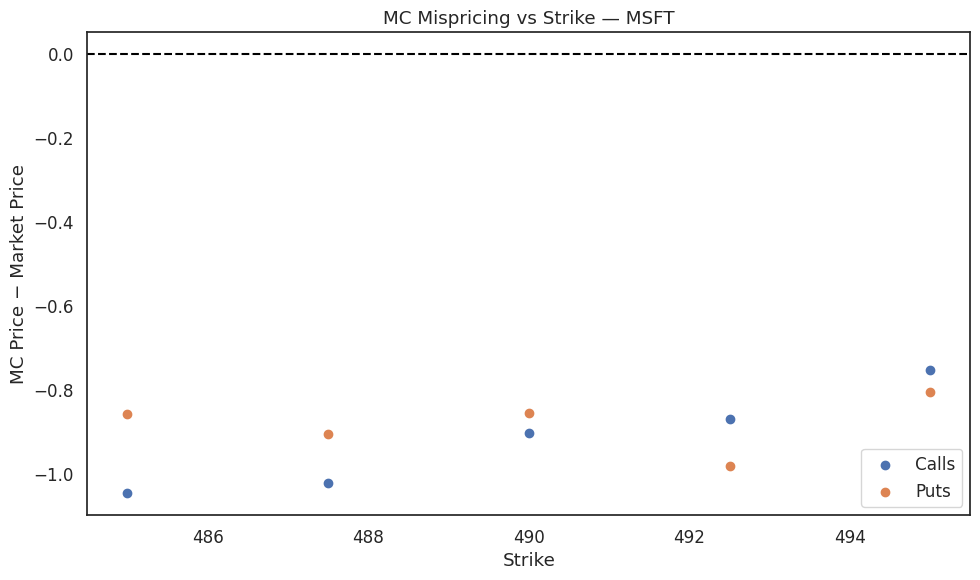


========== AMZN ==========
S0=234.42, mu=0.1556, sigma=0.3500
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


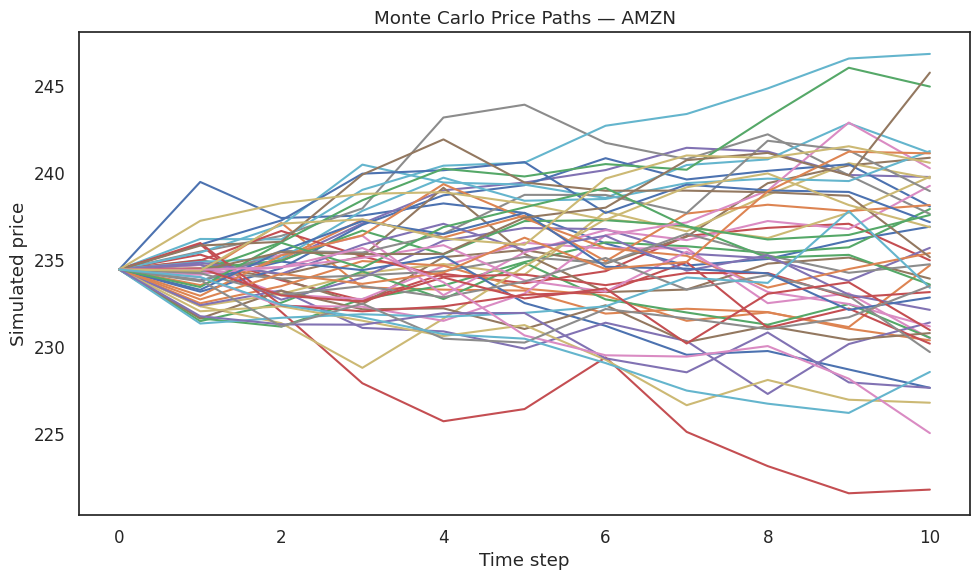

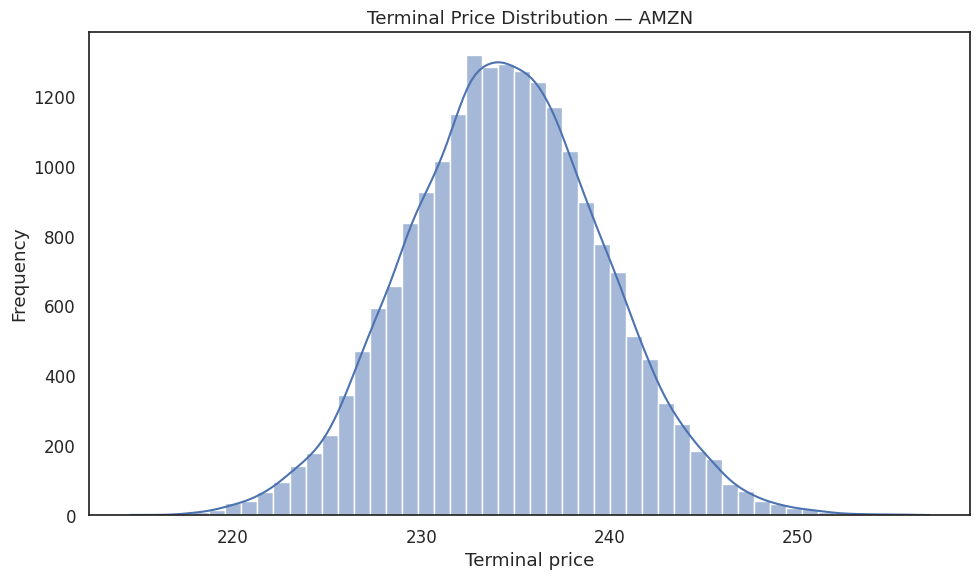

Pricing 5 calls & 5 puts


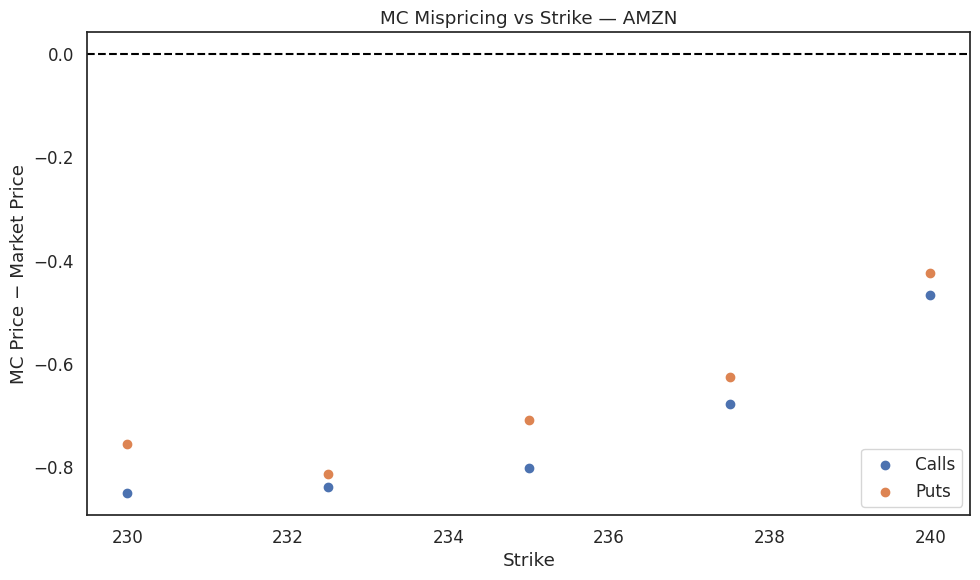


========== GOOGL ==========
S0=315.81, mu=0.6793, sigma=0.3341
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


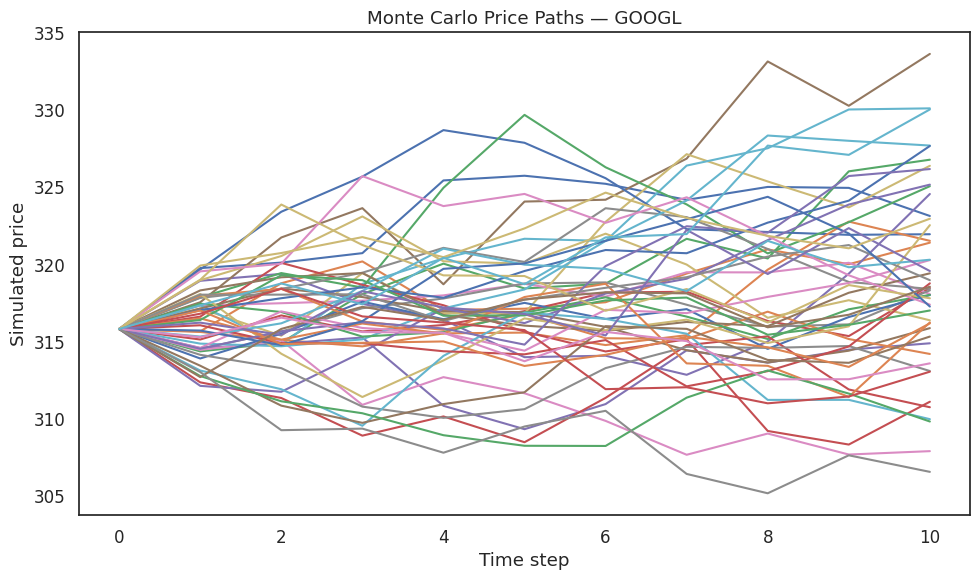

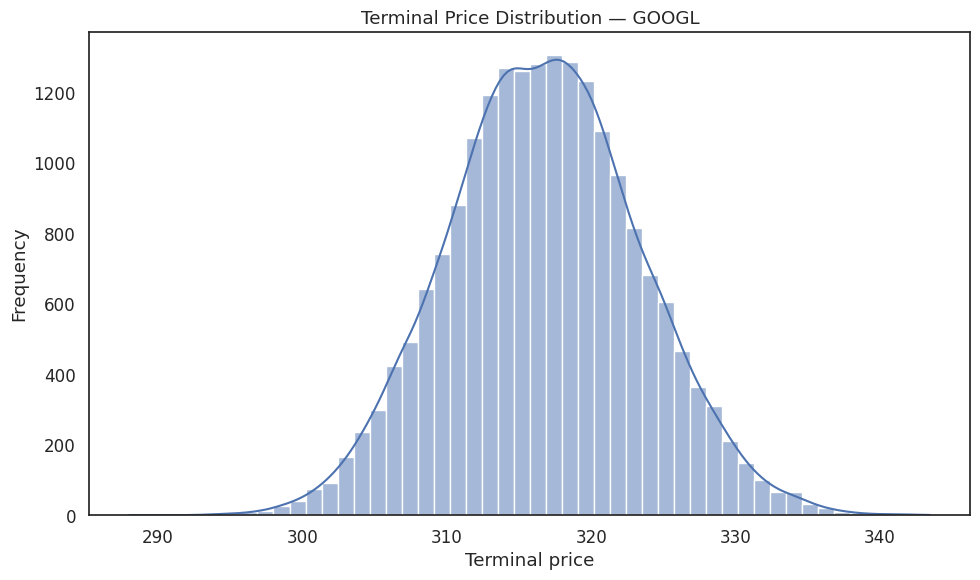

Pricing 5 calls & 5 puts


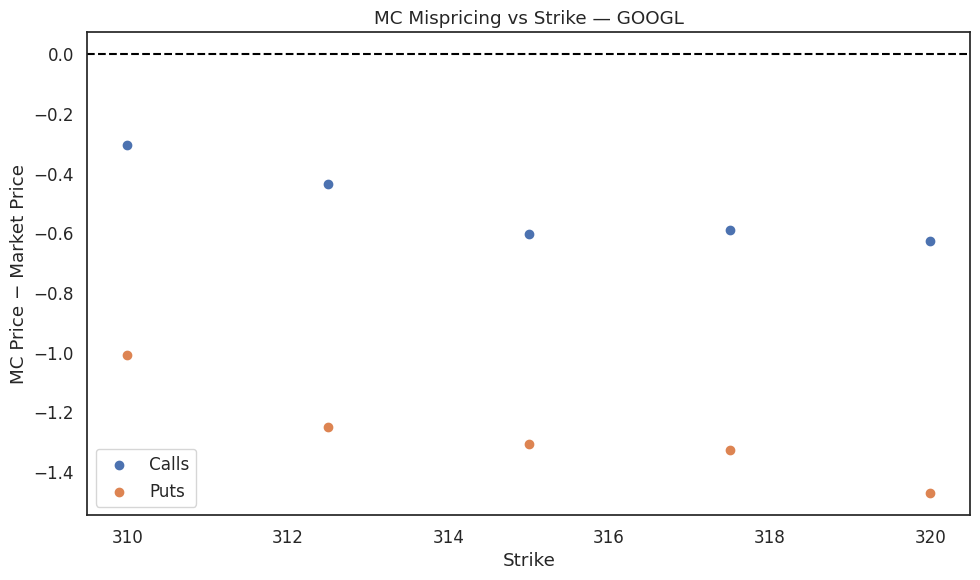


========== META ==========
S0=647.10, mu=0.1291, sigma=0.3825
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


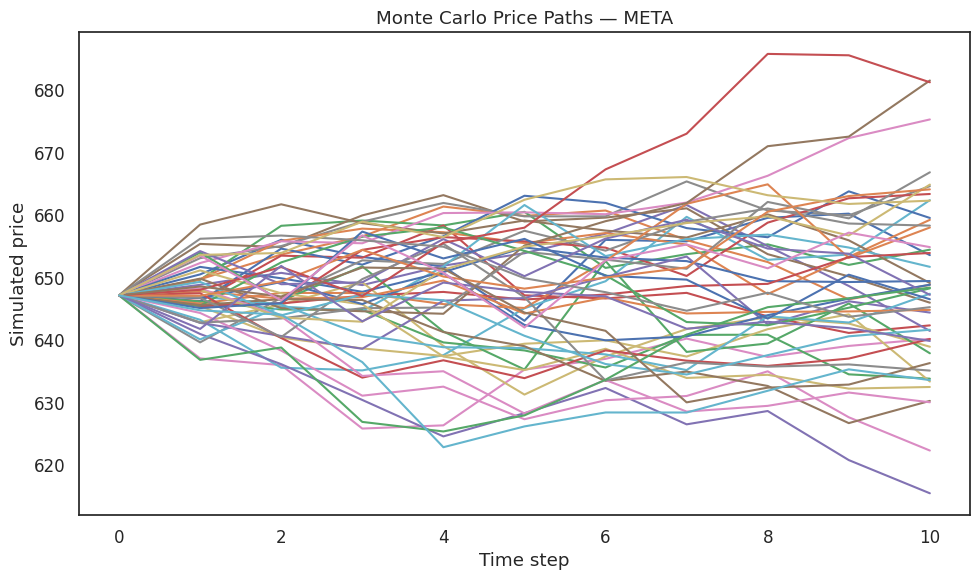

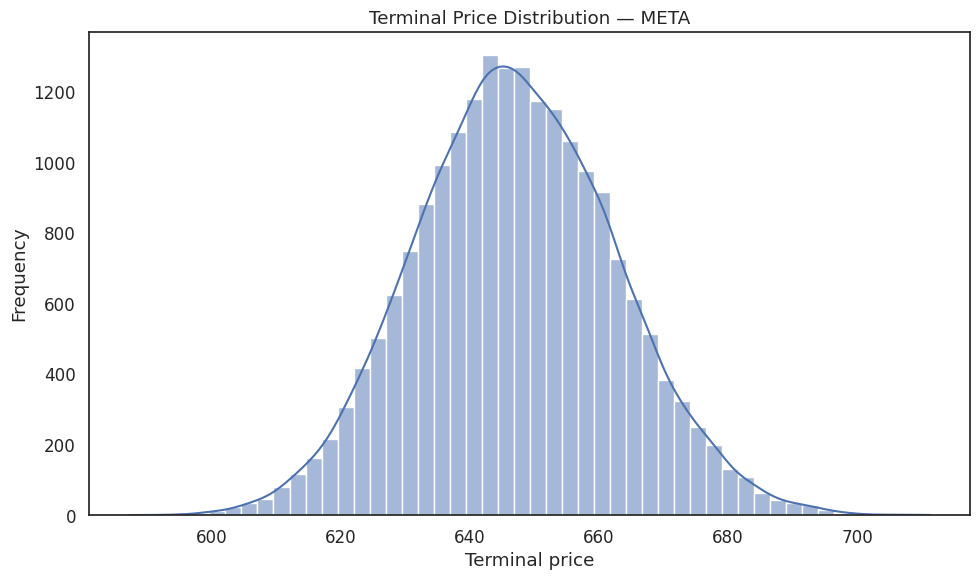

Pricing 5 calls & 5 puts


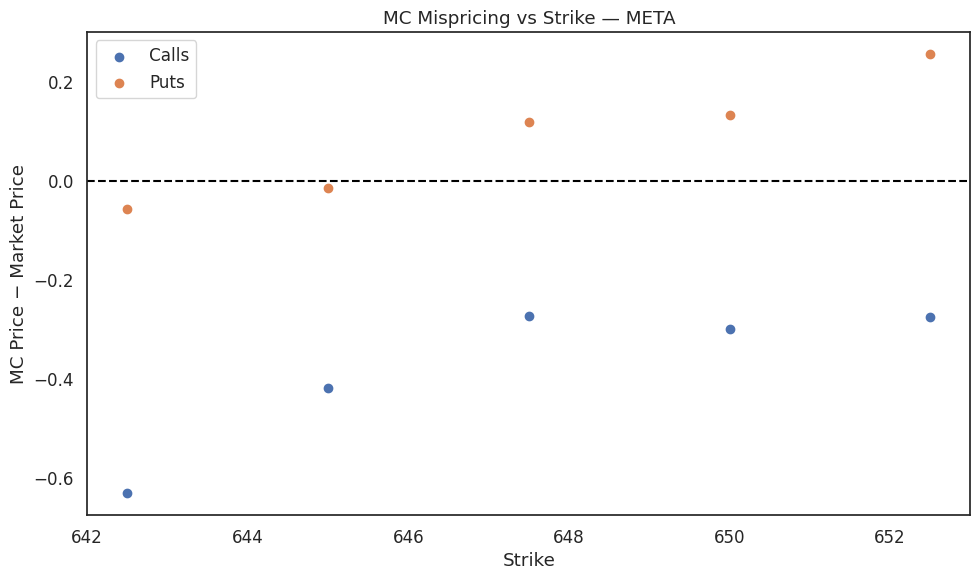


========== NVDA ==========
S0=181.46, mu=0.3856, sigma=0.4990
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


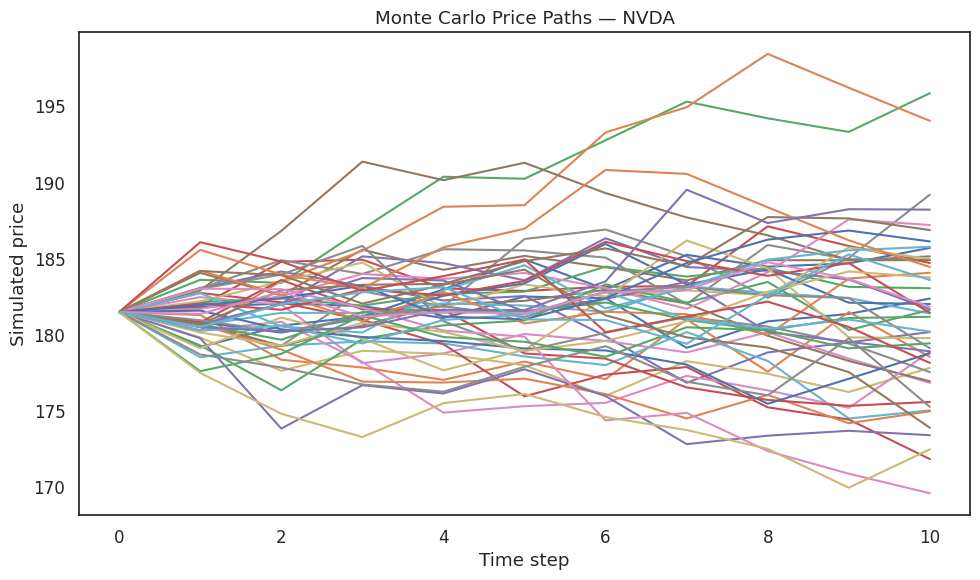

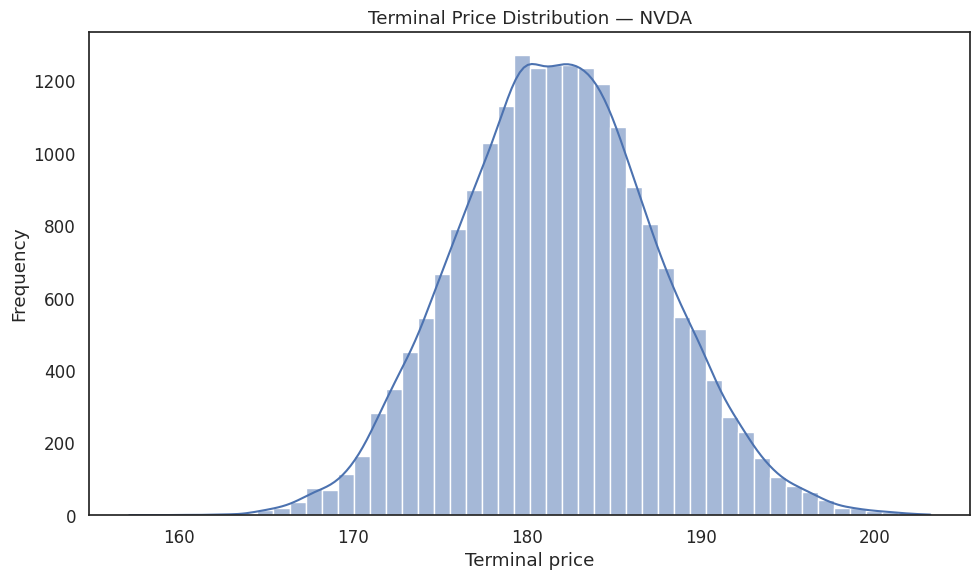

Pricing 5 calls & 5 puts


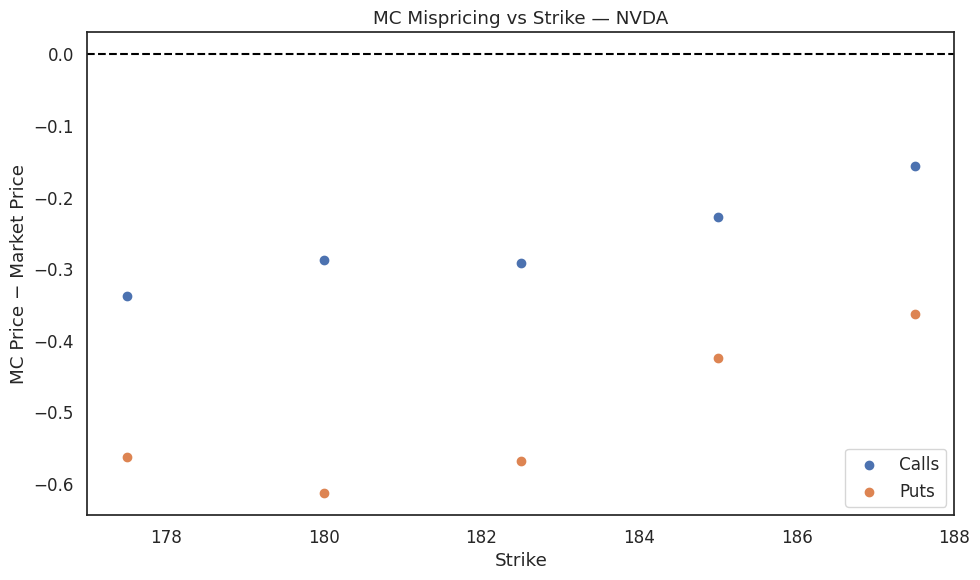


========== TSLA ==========
S0=429.24, mu=0.4142, sigma=0.6540
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


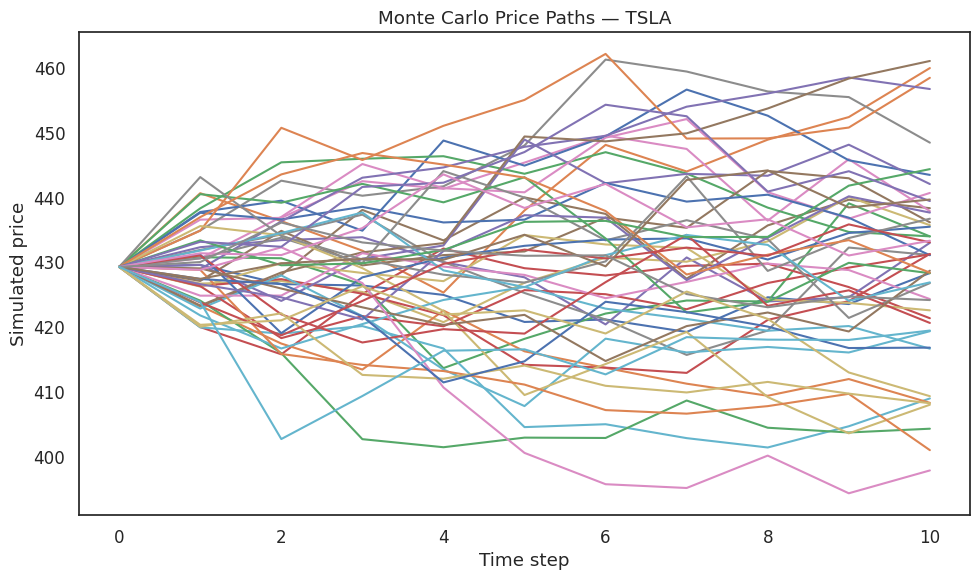

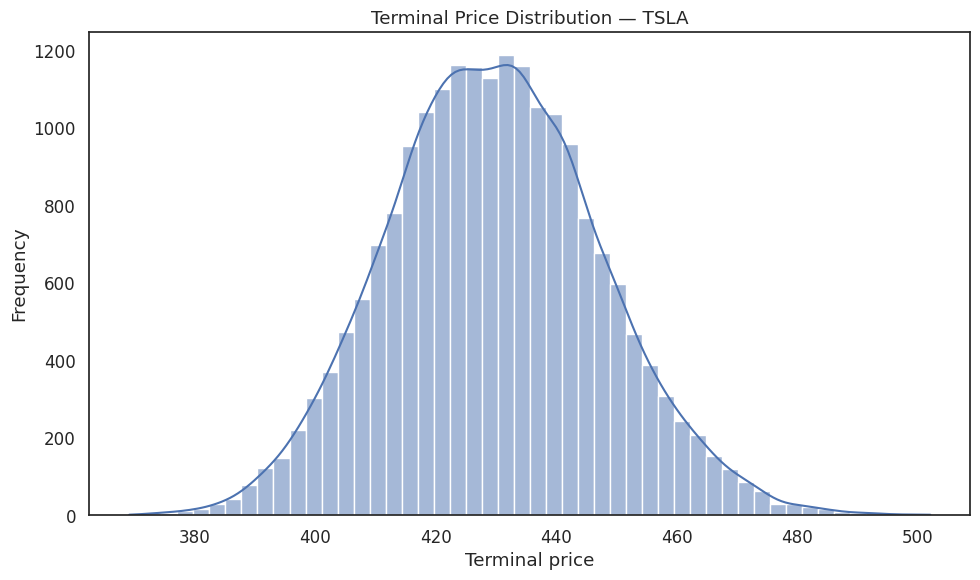

Pricing 5 calls & 5 puts


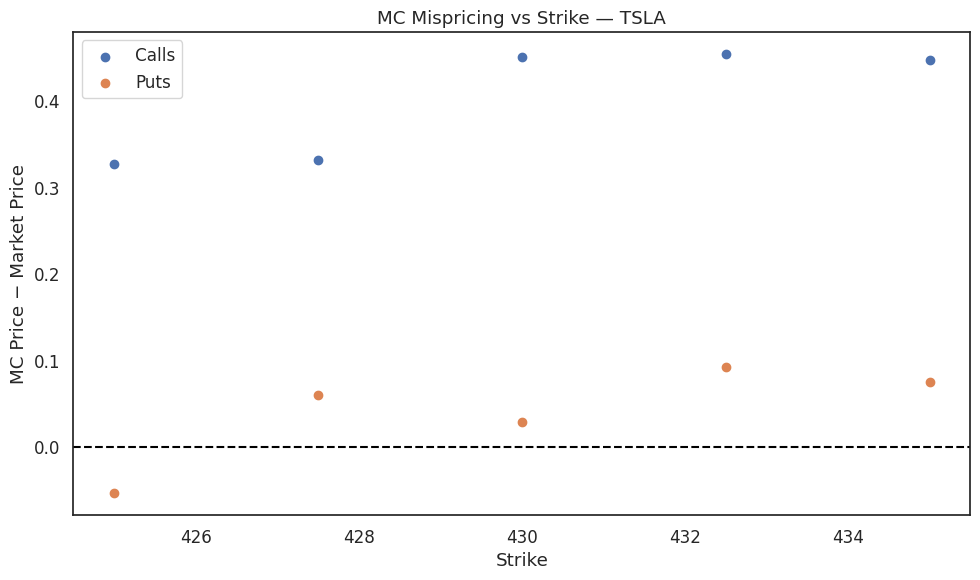


========== JPM ==========
S0=307.88, mu=0.2831, sigma=0.2438
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


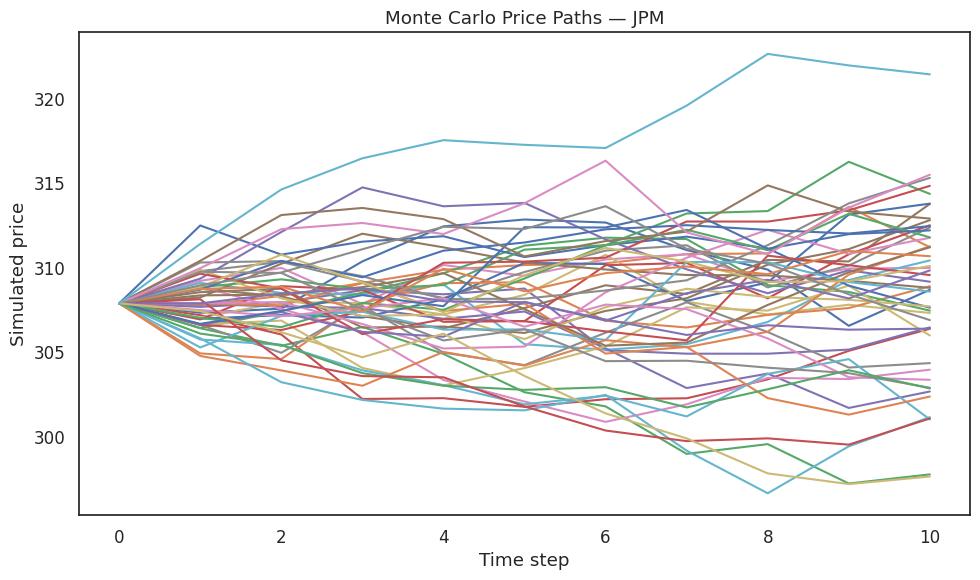

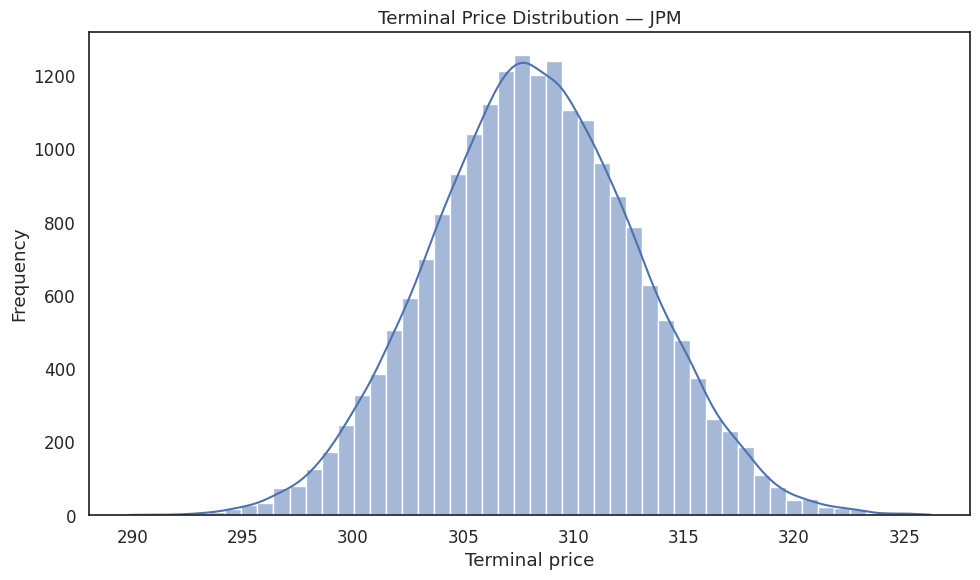

Pricing 5 calls & 5 puts


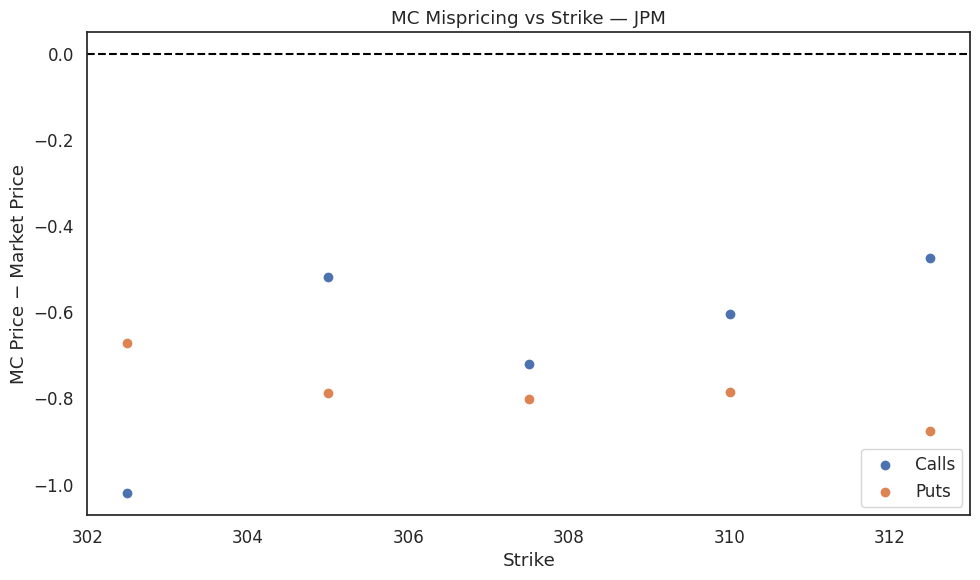


========== UNH ==========
S0=324.54, mu=-0.4842, sigma=0.4854
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


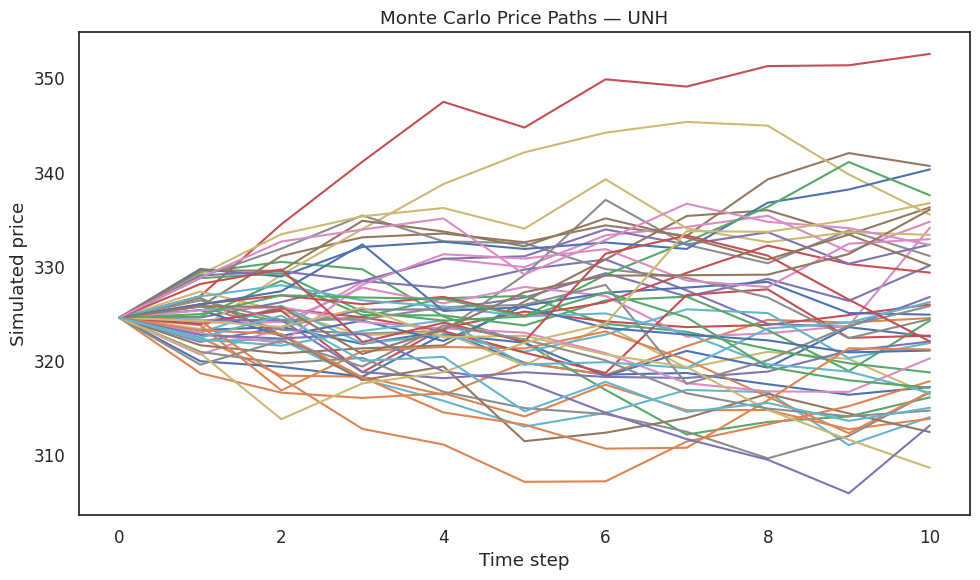

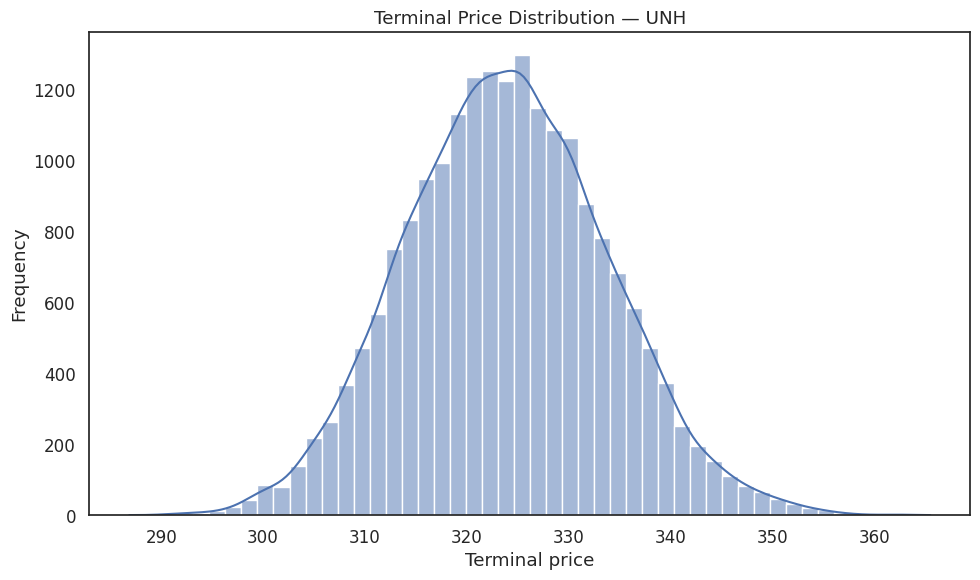

Pricing 5 calls & 5 puts


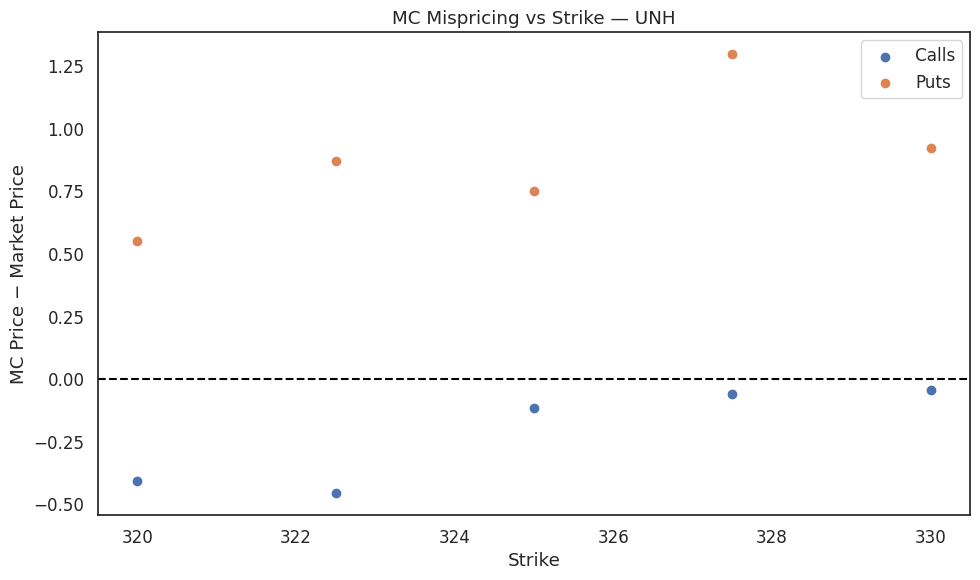


========== XOM ==========
S0=115.38, mu=0.0440, sigma=0.2334
Using expiry: 2025-12-05 — 1 days to expiry
Running Monte Carlo simulation...


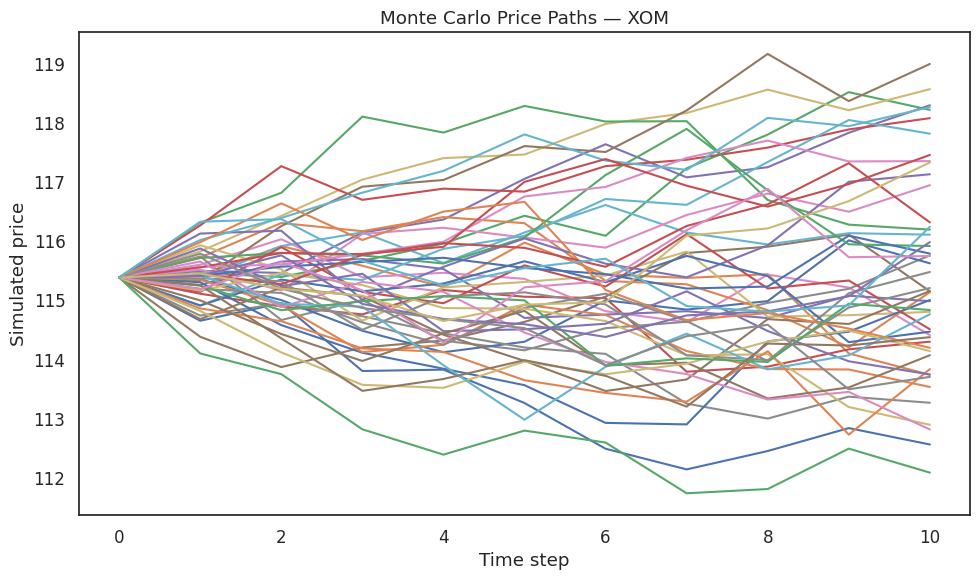

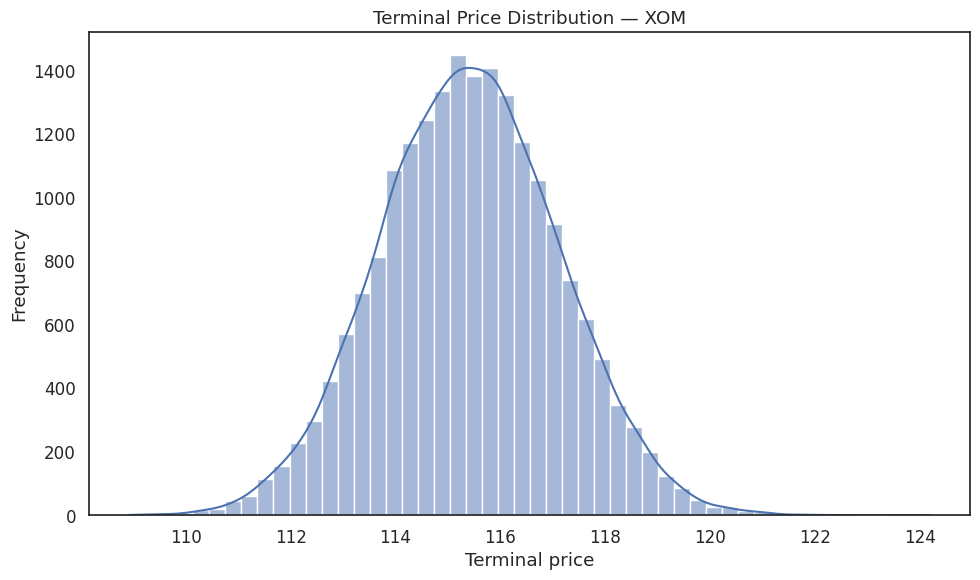

Pricing 5 calls & 5 puts


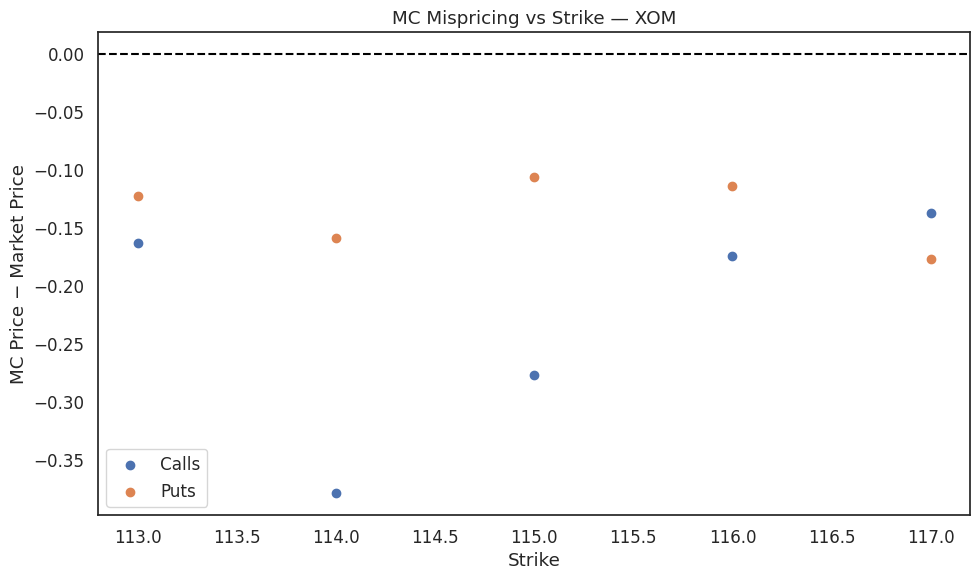


Saved: mc_options_pricing_multi_ticker_realtime.csv
  ticker      expiry type  strike        spot        mu     sigma  \
0   AAPL  2025-12-05    C   285.0  286.190002  0.224359  0.327356   
1   AAPL  2025-12-05    C   287.5  286.190002  0.224359  0.327356   
2   AAPL  2025-12-05    C   282.5  286.190002  0.224359  0.327356   
3   AAPL  2025-12-05    C   290.0  286.190002  0.224359  0.327356   
4   AAPL  2025-12-05    C   280.0  286.190002  0.224359  0.327356   
5   AAPL  2025-12-05    P   285.0  286.190002  0.224359  0.327356   
6   AAPL  2025-12-05    P   287.5  286.190002  0.224359  0.327356   
7   AAPL  2025-12-05    P   282.5  286.190002  0.224359  0.327356   
8   AAPL  2025-12-05    P   290.0  286.190002  0.224359  0.327356   
9   AAPL  2025-12-05    P   280.0  286.190002  0.224359  0.327356   

   market_price  mc_price  mispricing_mc_minus_mkt  
0          2.80  3.150482                 0.350482  
1          1.53  1.873652                 0.343652  
2          4.65  4.839983   

In [1]:
"""
REAL-TIME Monte Carlo Option Pricing MULTI-TICKER
+ intraday correlation heatmap
+ MC price paths
+ terminal distribution
+ mispricing vs strike graphs

This generates:
- correlation_heatmap_intraday.png
- mc_options_pricing_multi_ticker_realtime.csv

"""

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

# =========================================
# CONFIG
# =========================================

TICKERS = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META",
    "NVDA", "TSLA", "JPM", "UNH", "XOM",
]

INTRADAY_PERIOD = "5d"
INTRADAY_INTERVAL = "30m"

HIST_PERIOD_MC = "1y"

RISK_FREE_RATE = 0.05
MC_SIMS = 20_000
MC_STEPS_MAX = 252

N_OPTIONS_PER_SIDE = 5

HEATMAP_FILE = "correlation_heatmap_intraday.png"
OUTPUT_CSV = "mc_options_pricing_multi_ticker_realtime.csv"

SHOW_PLOTS = True
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)




def download_intraday_prices(tickers, period="5d", interval="30m"):
    print(f"Downloading intraday prices for {tickers} ...")
    data = yf.download(tickers, period=period, interval=interval)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data.dropna(how="all")


def download_daily_prices(tickers, period="1y"):
    print(f"Downloading daily prices for {tickers} ...")
    data = yf.download(tickers, period=period, interval="1d")["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data.dropna(how="all")


def compute_returns(price_df):
    return price_df.pct_change().dropna()




def plot_correlation_heatmap(returns_df, filename=None):
    corr = returns_df.corr()

    plt.figure(figsize=(12, 9))
    sns.set(style="white", font_scale=1.1)
    sns.heatmap(
        corr,
        cmap="coolwarm",
        linewidths=0.5,
        annot=False,
        square=True
    )
    plt.title("Intraday Correlation Heatmap (last 5 days, 30m bars)", fontsize=16)
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()




def mc_gbm_paths(S0, mu, sigma, T, n_steps, n_sims):
    dt = T / n_steps
    paths = np.zeros((n_steps + 1, n_sims))
    paths[0] = S0

    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_sims)
        paths[t] = paths[t - 1] * np.exp(
            (mu - 0.5 * sigma * sigma) * dt + sigma * np.sqrt(dt) * z
        )

    return paths


def mc_price_from_ST(ST, K, r, T, option_type="C"):
    if option_type == "C":
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * payoff.mean()




def plot_mc_price_paths(ticker, paths):
    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, :50])
    plt.title(f"Monte Carlo Price Paths — {ticker}")
    plt.xlabel("Time step")
    plt.ylabel("Simulated price")
    plt.tight_layout()
    plt.show()


def plot_mc_terminal_distribution(ticker, ST):
    plt.figure(figsize=(10, 6))
    sns.histplot(ST, bins=50, kde=True)
    plt.title(f"Terminal Price Distribution — {ticker}")
    plt.xlabel("Terminal price")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


def plot_mispricing_vs_strike(ticker, df):
    calls = df[df["type"] == "C"]
    puts = df[df["type"] == "P"]

    plt.figure(figsize=(10, 6))
    plt.scatter(calls["strike"], calls["mispricing_mc_minus_mkt"], label="Calls")
    plt.scatter(puts["strike"], puts["mispricing_mc_minus_mkt"], label="Puts")
    plt.axhline(0, linestyle="--", color="black")
    plt.title(f"MC Mispricing vs Strike — {ticker}")
    plt.xlabel("Strike")
    plt.ylabel("MC Price − Market Price")
    plt.legend()
    plt.tight_layout()
    plt.show()



def main():


    intraday = download_intraday_prices(TICKERS, INTRADAY_PERIOD, INTRADAY_INTERVAL)
    intraday_returns = compute_returns(intraday)

    if len(intraday_returns.columns) > 1:
        plot_correlation_heatmap(intraday_returns, filename=HEATMAP_FILE)


    daily = download_daily_prices(TICKERS, HIST_PERIOD_MC)
    daily_returns = compute_returns(daily)

    all_option_rows = []


    for ticker in TICKERS:
        print(f"\n========== {ticker} ==========")

        if ticker not in daily_returns.columns:
            print("No data — skipping.")
            continue

        rets = daily_returns[ticker]
        mu = rets.mean() * 252
        sigma = rets.std() * np.sqrt(252)
        S0 = float(daily[ticker].iloc[-1])

        print(f"S0={S0:.2f}, mu={mu:.4f}, sigma={sigma:.4f}")


        yt = yf.Ticker(ticker)
        expiries = yt.options
        if not expiries:
            print("No option chain — skip")
            continue

        # pick nearest > 1 day to expiry
        now = datetime.now(timezone.utc)
        chosen_exp = None

        for exp in expiries:
            exp_date = datetime.strptime(exp, "%Y-%m-%d").replace(tzinfo=timezone.utc)
            dte = (exp_date - now).days
            if dte >= 1:
                chosen_exp = exp
                days_to_expiry = dte
                break
        if chosen_exp is None:
            print("No suitable expiry — skip")
            continue

        print(f"Using expiry: {chosen_exp} — {days_to_expiry} days to expiry")

        T = days_to_expiry / 252
        steps = min(MC_STEPS_MAX, max(10, days_to_expiry))


        print("Running Monte Carlo simulation...")
        paths = mc_gbm_paths(S0, mu, sigma, T, steps, MC_SIMS)
        ST = paths[-1]

        if SHOW_PLOTS:
            plot_mc_price_paths(ticker, paths)
            plot_mc_terminal_distribution(ticker, ST)


        chain = yt.option_chain(chosen_exp)
        calls = chain.calls.copy()
        puts = chain.puts.copy()

        def pick(df):
            if df.empty: return df
            df = df.dropna(subset=["strike", "lastPrice"])
            df["dist"] = abs(df["strike"] - S0)
            df = df.sort_values("dist")
            return df.head(N_OPTIONS_PER_SIDE)

        sel_calls = pick(calls)
        sel_puts = pick(puts)

        print(f"Pricing {len(sel_calls)} calls & {len(sel_puts)} puts")

        #/calls
        for _, row in sel_calls.iterrows():
            K = float(row["strike"])
            market = float(row["lastPrice"])
            mc = mc_price_from_ST(ST, K, RISK_FREE_RATE, T, "C")

            all_option_rows.append({
                "ticker": ticker,
                "expiry": chosen_exp,
                "type": "C",
                "strike": K,
                "spot": S0,
                "mu": mu,
                "sigma": sigma,
                "market_price": market,
                "mc_price": mc,
                "mispricing_mc_minus_mkt": mc - market
            })

        #puts
        for _, row in sel_puts.iterrows():
            K = float(row["strike"])
            market = float(row["lastPrice"])
            mc = mc_price_from_ST(ST, K, RISK_FREE_RATE, T, "P")

            all_option_rows.append({
                "ticker": ticker,
                "expiry": chosen_exp,
                "type": "P",
                "strike": K,
                "spot": S0,
                "mu": mu,
                "sigma": sigma,
                "market_price": market,
                "mc_price": mc,
                "mispricing_mc_minus_mkt": mc - market
            })

        df_ticker_plot = pd.DataFrame(all_option_rows)
        df_ticker_plot = df_ticker_plot[df_ticker_plot["ticker"] == ticker]

        if SHOW_PLOTS:
            plot_mispricing_vs_strike(ticker, df_ticker_plot)


    results = pd.DataFrame(all_option_rows)
    results.to_csv(OUTPUT_CSV, index=False)
    print(f"\nSaved: {OUTPUT_CSV}")
    print(results.head(10))


if __name__ == "__main__":
    main()
